##### Data Dictionary:

### RATINGS FILE DESCRIPTION
=========================================================================
All ratings are contained in the file **"ratings.dat"** and are in the following format:
`UserID::MovieID::Rating::Timestamp`

- **UserIDs** range between **1 and 6040**
- **MovieIDs** range between **1 and 3952**
- **Ratings** are made on a **5-star scale** (whole-star ratings only)
- **Timestamp** is represented in **seconds**
- **Each user has at least 20 ratings**

---

### USERS FILE DESCRIPTION
=========================================================================
User information is in the file **"users.dat"** and is in the following format:
`UserID::Gender::Age::Occupation::Zip-code`

- All demographic information is provided voluntarily by the users and is **not checked for accuracy**.
- Only users who have provided some demographic information are included in this dataset.
- **Gender** is denoted by:
  - `"M"` for male
  - `"F"` for female

#### Age Groups:
- `1`: "Under 18"
- `18`: "18-24"
- `25`: "25-34"
- `35`: "35-44"
- `45`: "45-49"
- `50`: "50-55"
- `56`: "56+"

#### Occupations:
- `0`: "Other" or not specified
- `1`: "Academic/Educator"
- `2`: "Artist"
- `3`: "Clerical/Admin"
- `4`: "College/Grad Student"
- `5`: "Customer Service"
- `6`: "Doctor/Health Care"
- `7`: "Executive/Managerial"
- `8`: "Farmer"
- `9`: "Homemaker"
- `10`: "K-12 Student"
- `11`: "Lawyer"
- `12`: "Programmer"
- `13`: "Retired"
- `14`: "Sales/Marketing"
- `15`: "Scientist"
- `16`: "Self-Employed"
- `17`: "Technician/Engineer"
- `18`: "Tradesman/Craftsman"
- `19`: "Unemployed"
- `20`: "Writer"

---

### MOVIES FILE DESCRIPTION
=========================================================================
Movie information is in the file **"movies.dat"** and is in the following format:
`MovieID::Title::Genres`

- Titles are identical to those provided by IMDB (including year of release).
- Genres are **pipe (`|`) separated** and are selected from the following genres:

  - **Action**
  - **Adventure**
  - **Animation**
  - **Children's**
  - **Comedy**
  - **Crime**
  - **Documentary**
  - **Drama**
  - **Fantasy**
  - **Film-Noir**
  - **Horror**
  - **Musical**
  - **Mystery**
  - **Romance**
  - **Sci-Fi**
  - **Thriller**
  - **War**
  - **Western**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
from keras.src.losses import mean_squared_error
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import keras
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras.layers import dot
from pylab import rcParams
from cmfrec import CMF
from seaborn import color_palette

warnings.filterwarnings('ignore')

In [ ]:
users = pd.read_fwf('zee-users.dat', encoding="ISO-8859-1")
ratings = pd.read_fwf('zee-ratings.dat', encoding="ISO-8859-1")
movies = pd.read_fwf('zee-movies.dat', encoding="ISO-8859-1")

In [ ]:
users.head()

UserID::Gender::Age::Occupation::Zip-code
0                        1::F::1::10::48067
1                       2::M::56::16::70072
2                       3::M::25::15::55117
3                        4::M::45::7::02460
4                       5::M::25::20::55455

In [ ]:
ratings.head()

UserID::MovieID::Rating::Timestamp
0              1::1193::5::978300760
1               1::661::3::978302109
2               1::914::3::978301968
3              1::3408::4::978300275
4              1::2355::5::978824291

In [ ]:
movies.head()

Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN
2        3::Grumpier Old Men (1995)::Comedy|Romance        NaN        NaN
3         4::Waiting to Exhale (1995)::Comedy|Drama        NaN        NaN
4     5::Father of the Bride Part II (1995)::Comedy        NaN        NaN

In [ ]:
# Splitting the rows in each table seperated by '::'
delimit = '::'
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimit, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users.head()

UserID Gender Age Occupation Zip-code
0      1      F   1         10    48067
1      2      M  56         16    70072
2      3      M  25         15    55117
3      4      M  45          7    02460
4      5      M  25         20    55455

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimit, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head()

UserID MovieID Rating  Timestamp
0      1    1193      5  978300760
1      1     661      3  978302109
2      1     914      3  978301968
3      1    3408      4  978300275
4      1    2355      5  978824291

In [ ]:
movies = movies['Movie ID::Title::Genres'].str.split(delimit, expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']
movies.head()

Movie ID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [ ]:
# We notice that there are only 7 unique Age values, which represent a range.
users['Age'].value_counts()

Age
25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: count, dtype: int64

In [ ]:
# Binning the age column.
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [ ]:
# Replacing the occupation values with their corresponding occupation names.
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [ ]:
# Correcting 'MovieID' column name.
movies.columns = ['MovieID', 'Title', 'Genres']
movies.head()

MovieID                               Title                        Genres
0       1                    Toy Story (1995)   Animation|Children's|Comedy
1       2                      Jumanji (1995)  Adventure|Children's|Fantasy
2       3             Grumpier Old Men (1995)                Comedy|Romance
3       4            Waiting to Exhale (1995)                  Comedy|Drama
4       5  Father of the Bride Part II (1995)                        Comedy

In [ ]:
# Merging movies and ratings.
df1 = pd.merge(movies, ratings, on='MovieID', how='inner')
df1.head()

MovieID             Title                       Genres UserID Rating  \
0       1  Toy Story (1995)  Animation|Children's|Comedy      1      5   
1       1  Toy Story (1995)  Animation|Children's|Comedy      6      4   
2       1  Toy Story (1995)  Animation|Children's|Comedy      8      4   
3       1  Toy Story (1995)  Animation|Children's|Comedy      9      5   
4       1  Toy Story (1995)  Animation|Children's|Comedy     10      5   

   Timestamp  
0  978824268  
1  978237008  
2  978233496  
3  978225952  
4  978226474

In [ ]:
# Merging with users.
df2 = pd.merge(df1, users, on='UserID', how='inner')
df2.head()

MovieID             Title                       Genres UserID Rating  \
0       1  Toy Story (1995)  Animation|Children's|Comedy      1      5   
1       1  Toy Story (1995)  Animation|Children's|Comedy      6      4   
2       1  Toy Story (1995)  Animation|Children's|Comedy      8      4   
3       1  Toy Story (1995)  Animation|Children's|Comedy      9      5   
4       1  Toy Story (1995)  Animation|Children's|Comedy     10      5   

   Timestamp Gender       Age           Occupation Zip-code  
0  978824268      F  Under 18         k-12 student    48067  
1  978237008      F     50-55            homemaker    55117  
2  978233496      M     25-34           programmer    11413  
3  978225952      M     25-34  technician/engineer    61614  
4  978226474      F     35-44    academic/educator    95370

In [ ]:
df_final = df2.copy(deep=True)

In [ ]:
print("No. of rows: ", df_final.shape[0])
print("No. of columns: ", df_final.shape[1])

No. of rows:  1000209
No. of columns:  10


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   MovieID     1000209 non-null  object
 1   Title       1000209 non-null  object
 2   Genres      996144 non-null   object
 3   UserID      1000209 non-null  object
 4   Rating      1000209 non-null  object
 5   Timestamp   1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  object
 8   Occupation  1000209 non-null  object
 9   Zip-code    1000209 non-null  object
dtypes: object(10)
memory usage: 76.3+ MB


#### Feature Engineering

In [ ]:
# Converting rating column to integer type.
df_final['Rating'] = df_final['Rating'].astype(int)

In [ ]:
# We have the timestamp given to us in seconds, so converting it to datetime.
df_final['Timestamp'] = pd.to_datetime(df_final['Timestamp'], unit='s')

In [ ]:
df_final.sample(50)

MovieID                                              Title  \
259964    1073       Willy Wonka and the Chocolate Factory (1971)   
243810    1009                    Escape to Witch Mountain (1975)   
154907     562                    Welcome to the Dollhouse (1995)   
305500    1200                                      Aliens (1986)   
124963     460                       Getting Even with Dad (1994)   
557506    2028                         Saving Private Ryan (1998)   
88762      329                      Star Trek: Generations (1994)   
13658       28                                  Persuasion (1995)   
140027     517                                  Rising Sun (1993)   
408242    1387                                        Jaws (1975)   
291414    1183                        English Patient, The (1996)   
677760    2495  Fantastic Planet, The (La Planète sauvage) (1973)   
40572      144                      Brothers McMullen, The (1995)   
635124    2353                          Enemy of the State (1998)   
728802    2707                              Arlington Road (1999)   
629007    2330                        Hands on a Hard Body (1996)   
383700    1307                     When Harry Met Sally... (1989)   
778649    2905                                     Sanjuro (1962)   
529928    1964                                       Klute (1971)   
337363    1240                             Terminator, The (1984)   
434391    1527                          Fifth Element, The (1997)   
607237    2243                              Broadcast News (1987)   
585768    2128                                    Safe Men (1998)   
514455    1920                              Small Soldiers (1998)   
997860    3934                                      Kronos (1957)   
915161    3498                            Midnight Express (1978)   
854510    3189                                 My Dog Skip (1999)   
642921    2375                              Money Pit, The (1986)   
919116    3510                                   Frequency (2000)   
466767    1653                                     Gattaca (1997)   
565251    2067                              Doctor Zhivago (1965)   
617946    2291                         Edward Scissorhands (1990)   
383136    1307                     When Harry Met Sally... (1989)   
877540    3301                       Whole Nine Yards, The (2000)   
229679     924                       2001: A Space Odyssey (1968)   
319135    1214                                       Alien (1979)   
561388    2054                    Honey, I Shrunk the Kids (1989)   
765299    2841                              Stir of Echoes (1999)   
470722    1674                                     Witness (1985)   
780311    2912                                  Limey, The (1999)   
265275    1083                             Great Race, The (1965)   
671406    2463                             Ruthless People (1986)   
701485    2606                                  Idle Hands (1999)   
355478    1265                               Groundhog Day (1993)   
348368    1256                                   Duck Soup (1933)   
967143    3743                              Boys and Girls (2000)   
460819    1630                        Lay of the Land, The (1997)   
651237    2396                         Shakespeare in Love (1998)   
159252     588                                     Aladdin (1992)   
464346    1644             I Know What You Did Last Summer (1997)   

                                     Genres UserID  Rating  \
259964                  Adventure|Children'    249       4   
243810         Adventure|Children's|Fantasy   5938       4   
154907                         Comedy|Drama   1242       5   
305500           Action|Sci-Fi|Thriller|War   1917       4   
124963                               Comedy   1841       3   
557506                     Action|Drama|War   5838       3   
88762               Action|Adventure|Sci-Fi   4957   

In [ ]:
# Extracting release year from the title and storing it in a new column.
df_final['Release Year'] = df_final['Title'].str.strip().str[-5:-1]
df_final.head()

MovieID             Title                       Genres UserID  Rating  \
0       1  Toy Story (1995)  Animation|Children's|Comedy      1       5   
1       1  Toy Story (1995)  Animation|Children's|Comedy      6       4   
2       1  Toy Story (1995)  Animation|Children's|Comedy      8       4   
3       1  Toy Story (1995)  Animation|Children's|Comedy      9       5   
4       1  Toy Story (1995)  Animation|Children's|Comedy     10       5   

            Timestamp Gender       Age           Occupation Zip-code  \
0 2001-01-06 23:37:48      F  Under 18         k-12 student    48067   
1 2000-12-31 04:30:08      F     50-55            homemaker    55117   
2 2000-12-31 03:31:36      M     25-34           programmer    11413   
3 2000-12-31 01:25:52      M     25-34  technician/engineer    61614   
4 2000-12-31 01:34:34      F     35-44    academic/educator    95370   

  Release Year  
0         1995  
1         1995  
2         1995  
3         1995  
4         1995

In [ ]:
# We notice some incorrect year values.
df_final['Release Year'].unique()

array(['1995', '1994', '1996', 'n th', '1976', '1993', '1992', '1988',
       '1967', '964)', '1977', 'der ', '1965', '(199', '1982', '1962',
       '1990', '1991', '1989', '1937', '1940', '1969', '1981', '1973',
       '1970', '1960', '1955', '1956', '1959', '1968', '1980', '1975',
       '995)', '1948', '1943', 'he B', '1950', '1987', '1997', ' Art',
       '1974', '1958', '1972', '1998', '1952', '1951', '1957', '1961',
       '1954', '1934', '1944', '1963', '1942', '1941', '1964', '1953',
       '1939', '1947', '1946', '1945', '1938', '1935', '1936', '1926',
       '1949', '1932', '1930', '1971', '1979', '1986', '1966', '1978',
       '1985', '1983', '1984', '1933', '1931', '1922', ') (1', '1927',
       '1929', ' (19', '1928', '1999', "e d'", 'olar', '(196', '1925',
       '981)', '1919', '(198', 'nd) ', '1923', '2000', 'n) (', '1920',
       '1921', 'dron', 'e (1', '989)'], dtype=object)

In [ ]:
# Replacing incorrect year values where possible.
df_final['Release Year'].replace({'964)': '1964', '995)': '1995', '981)': '1981', '989)': '1989'}, inplace=True)
df_final['Release Year'].unique()

array(['1995', '1994', '1996', 'n th', '1976', '1993', '1992', '1988',
       '1967', '1964', '1977', 'der ', '1965', '(199', '1982', '1962',
       '1990', '1991', '1989', '1937', '1940', '1969', '1981', '1973',
       '1970', '1960', '1955', '1956', '1959', '1968', '1980', '1975',
       '1948', '1943', 'he B', '1950', '1987', '1997', ' Art', '1974',
       '1958', '1972', '1998', '1952', '1951', '1957', '1961', '1954',
       '1934', '1944', '1963', '1942', '1941', '1953', '1939', '1947',
       '1946', '1945', '1938', '1935', '1936', '1926', '1949', '1932',
       '1930', '1971', '1979', '1986', '1966', '1978', '1985', '1983',
       '1984', '1933', '1931', '1922', ') (1', '1927', '1929', ' (19',
       '1928', '1999', "e d'", 'olar', '(196', '1925', '1919', '(198',
       'nd) ', '1923', '2000', 'n) (', '1920', '1921', 'dron', 'e (1'],
      dtype=object)

In [ ]:
# Dropping rows where the years do not make sense.

idx_val = df_final[(df_final['Release Year']=='n th') |
               (df_final['Release Year']=='der ') |
               (df_final['Release Year']=='(199') |
               (df_final['Release Year']=='he B') |
               (df_final['Release Year']==' Art') |
               (df_final['Release Year']==') (1') |
               (df_final['Release Year']==' (19') |
               (df_final['Release Year']=='Polar') |
               (df_final['Release Year']=="e d'") |
               (df_final['Release Year']=='olar') |
               (df_final['Release Year']=='(196') |
                (df_final['Release Year']=='(198') |
                (df_final['Release Year']=='nd) ') |
                (df_final['Release Year']=='n) (') |
                (df_final['Release Year']=='dron') |
                (df_final['Release Year']=='e (1')].index

df_final.drop(index=idx_val, inplace=True)
df_final['Release Year'].unique()

array(['1995', '1994', '1996', '1976', '1993', '1992', '1988', '1967',
       '1964', '1977', '1965', '1982', '1962', '1990', '1991', '1989',
       '1937', '1940', '1969', '1981', '1973', '1970', '1960', '1955',
       '1956', '1959', '1968', '1980', '1975', '1948', '1943', '1950',
       '1987', '1997', '1974', '1958', '1972', '1998', '1952', '1951',
       '1957', '1961', '1954', '1934', '1944', '1963', '1942', '1941',
       '1953', '1939', '1947', '1946', '1945', '1938', '1935', '1936',
       '1926', '1949', '1932', '1930', '1971', '1979', '1986', '1966',
       '1978', '1985', '1983', '1984', '1933', '1931', '1922', '1927',
       '1929', '1928', '1999', '1925', '1919', '1923', '2000', '1920',
       '1921'], dtype=object)

In [ ]:
# Converting 'Release Year' to int data type.
df_final['Release Year'] = df_final['Release Year'].astype(int)

In [ ]:
df_final.sample(5)

MovieID                                      Title  \
959762    3704          Mad Max Beyond Thunderdome (1985)   
560494    2053            Honey, I Blew Up the Kid (1992)   
105037     370  Naked Gun 33 1/3: The Final Insult (1994)   
287731    1171                         Bob Roberts (1992)   
46594      162                               Crumb (1994)   

                          Genres UserID  Rating           Timestamp Gender  \
959762             Action|Sci-Fi   3539       4 2000-08-23 07:35:53      F   
560494  Children's|Comedy|Sci-Fi    216       1 2000-12-15 08:06:45      M   
105037                    Comedy   3922       4 2000-08-08 05:32:31      M   
287731                    Comedy   1531       3 2000-11-20 18:22:17      M   
46594                Documentary   2020       5 2000-11-19 22:47:52      M   

          Age            Occupation Zip-code  Release Year  
959762  25-34  college/grad student    77006          1985  
560494  45-49               retired    52761          1992  
105037  18-24  college/grad student    53211          1994  
287731  45-49   technician/engineer    60462          1992  
46594   25-34  executive/managerial    45011          1994

In [ ]:
# Creating the title column with only the title names.
df_final['Title'] = df_final['Title'].str.strip().str[:-7]
df_final.sample(5)

MovieID               Title                       Genres UserID  \
761138    2808   Universal Soldier                Action|Sci-Fi   2261   
837686    3114         Toy Story 2  Animation|Children's|Comedy   3665   
380042    1302     Field of Dreams                        Drama    904   
907819    3468        Hustler, The                        Drama   5353   
225926     920  Gone with the Wind            Drama|Romance|War   1112   

        Rating           Timestamp Gender    Age          Occupation Zip-code  \
761138       3 2000-11-18 21:28:57      M  25-34    customer service    33025   
837686       4 2000-11-11 00:05:12      M  25-34               other    95903   
380042       2 2000-12-28 23:19:58      M  35-44              writer    92308   
907819       5 2000-06-10 05:54:31      M  25-34  doctor/health care    77030   
225926       5 2000-11-23 02:22:47      M  18-24  doctor/health care    19104   

        Release Year  
761138          1992  
837686          1999  
380042          1989  
907819          1961  
225926          1939

In [ ]:
# Creating a new column indicating the decade the movie was released.
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
df_final['ReleaseDec'] = pd.cut(df_final['Release Year'], bins=bins, labels=labels)
df_final.sample(5)

MovieID                                      Title            Genres  \
979560    3795                           Five Senses, The             Drama   
17738       35                                 Carrington     Drama|Romance   
252632    1036                                   Die Hard   Action|Thriller   
286879    1148                        Wrong Trousers, The  Animation|Comedy   
706638    2628  Star Wars: Episode I - The Phantom Menace   Action|Adventur   

       UserID  Rating           Timestamp Gender    Age            Occupation  \
979560   1224       4 2000-11-27 22:40:43      M  50-55               retired   
17738    5556       5 2000-05-27 16:31:39      M  45-49    doctor/health care   
252632    329       4 2000-12-10 18:47:13      M  35-44  executive/managerial   
286879   5556       4 2000-05-27 16:02:53      M  45-49    doctor/health care   
706638   4786       5 2000-07-07 20:04:56      M  45-49    doctor/health care   

       Zip-code  Release Year ReleaseDec  
979560    02125          1999        90s  
17738     92103          1995        90s  
252632    02115          1988        80s  
286879    92103          1993        90s  
706638    22630          1999        90s

#### Data Cleaning

In [ ]:
# Checking nulls
df_final.isna().sum()

MovieID           0
Title             0
Genres          521
UserID            0
Rating            0
Timestamp         0
Gender            0
Age               0
Occupation        0
Zip-code          0
Release Year      0
ReleaseDec       45
dtype: int64

In [ ]:
df_final[df_final['Genres'].isna()]

MovieID                                              Title Genres  \
55005      199  Umbrellas of Cherbourg, The (Parapluies de Che...   None   
55006      199  Umbrellas of Cherbourg, The (Parapluies de Che...   None   
55007      199  Umbrellas of Cherbourg, The (Parapluies de Che...   None   
55008      199  Umbrellas of Cherbourg, The (Parapluies de Che...   None   
55009      199  Umbrellas of Cherbourg, The (Parapluies de Che...   None   
...        ...                                                ...    ...   
954197    3695  Toxic Avenger Part III: The Last Temptation of...   None   
954198    3695  Toxic Avenger Part III: The Last Temptation of...   None   
954199    3695  Toxic Avenger Part III: The Last Temptation of...   None   
954200    3695  Toxic Avenger Part III: The Last Temptation of...   None   
954201    3695  Toxic Avenger Part III: The Last Temptation of...   None   

       UserID  Rating           Timestamp Gender    Age            Occupation  \
55005       6       5 2000-12-31 04:39:30      F  50-55             homemaker   
55006      53       5 2000-12-28 04:59:11      M  25-34                 other   
55007      59       3 2003-01-07 19:16:09      F  50-55     academic/educator   
55008      78       4 2000-12-26 06:24:55      F  45-49     academic/educator   
55009     155       4 2000-12-19 19:14:14      M  35-44            programmer   
...       ...     ...                 ...    ...    ...                   ...   
954197   4715       1 2000-07-13 22:35:22      M  25-34                artist   
954198   4788       3 2000-07-07 19:13:45      M  35-44  executive/managerial   
954199   4972       2 2000-07-03 06:43:32      M  35-44                 other   
954200   4979       2 2000-07-03 07:12:12      M  35-44                artist   
954201   5137       1 2000-06-27 01:37:14      M  18-24   tradesman/craftsman   

       Zip-code  Release Year ReleaseDec  
55005     55117          1964        60s  
55006     96931          1964        60s  
55007     55413          1964        60s  
55008     98029          1964        60s  
55009     07470          1964        60s  
...         ...           ...        ...  
954197    97205          1989        80s  
954198    85331          1989        80s  
954199    95118          1989        80s  
954200    55423          1989        80s  
954201    65265          1989        80s  

[521 rows x 12 columns]

#### Exploratory Data Analysis and Visualization

In [ ]:
df_final.sample(5)

MovieID            Title          Genres UserID  Rating  \
660609    2419      Extremities  Drama|Thriller   2733       4   
666060    2433  Civil Action, A           Drama   4444       4   
362796    1272           Patton       Drama|War   3216       4   
734618    2716     Ghostbusters   Comedy|Horror   6021       3   
711949    2653   Son of Dracula          Horror   5954       3   

                 Timestamp Gender    Age           Occupation Zip-code  \
660609 2000-11-03 06:28:37      M  45-49  technician/engineer    94002   
666060 2000-08-01 00:33:11      F  25-34           programmer    80126   
362796 2000-09-09 01:17:20      M  35-44    academic/educator    54481   
734618 2000-04-26 13:55:42      M  25-34           programmer    08876   
711949 2000-05-07 13:14:43      M  45-49               lawyer    70802   

        Release Year ReleaseDec  
660609          1986        80s  
666060          1998        90s  
362796          1970        70s  
734618          1984        80s  
711949          1943        40s

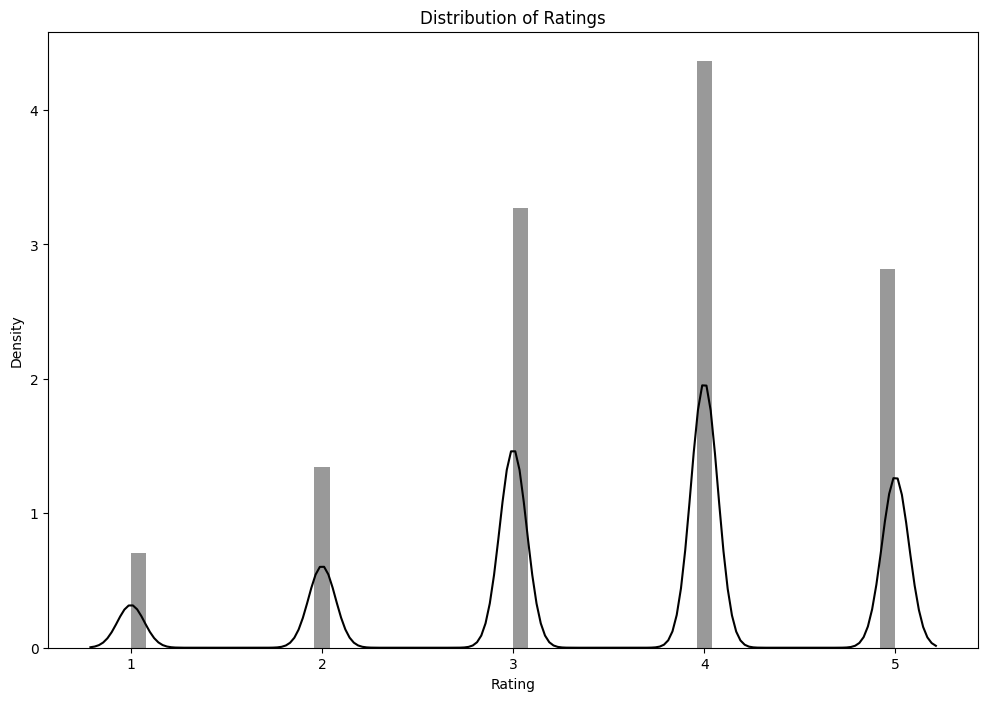

In [ ]:
# Distribution of Ratings
plt.figure(figsize=(12, 8))
sns.distplot(df_final['Rating'], color='black', label='Rating')
plt.title('Distribution of Ratings')
plt.show()

##### From the above distribution we can observe that most of the movies are given rating 4.0

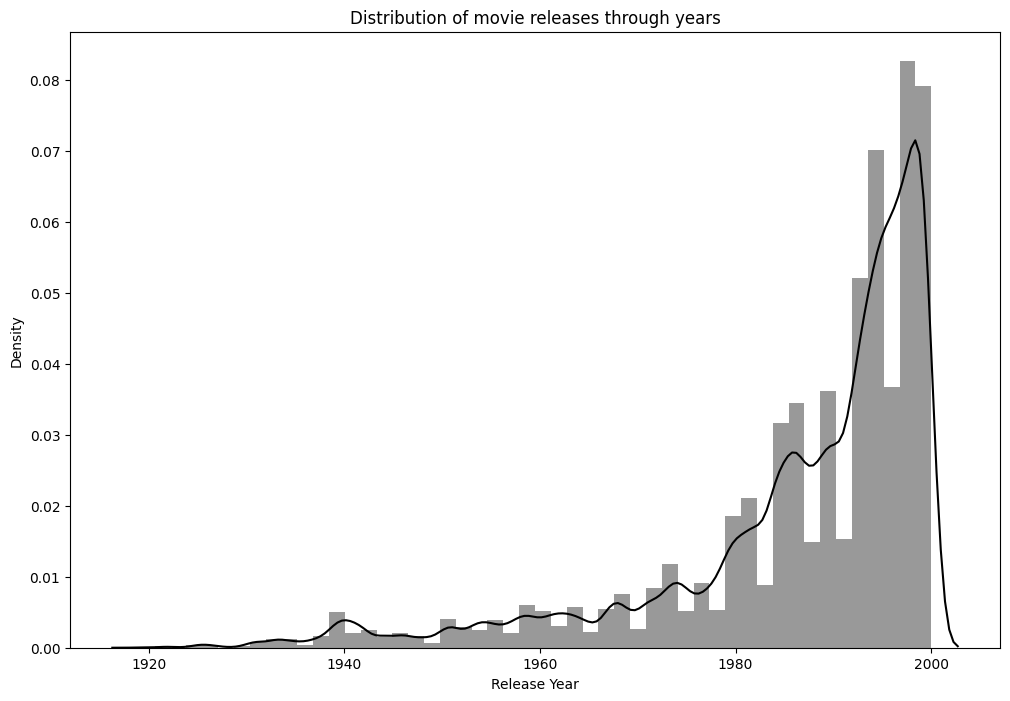

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Distribution of movies released through the years.
plt.figure(figsize=(12, 8))
sns.distplot(df_final['Release Year'], color='black', label='Release Year')
plt.title('Distribution of movie releases through years')
plt.figure(figsize=(12, 8))
plt.show()

##### As expected movie releases increase over the years, as validated by the above left skewed distribution.

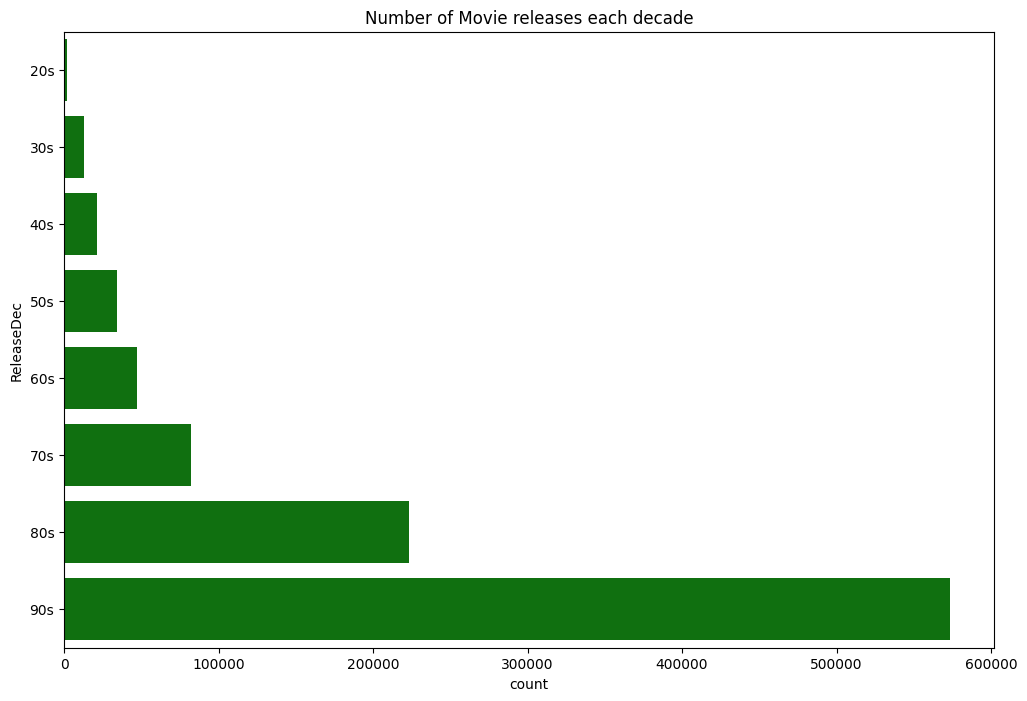

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(df_final['ReleaseDec'], color='green')
plt.title('Number of Movie releases each decade')
plt.show()

##### From our data, most of the movies are released in the 90s

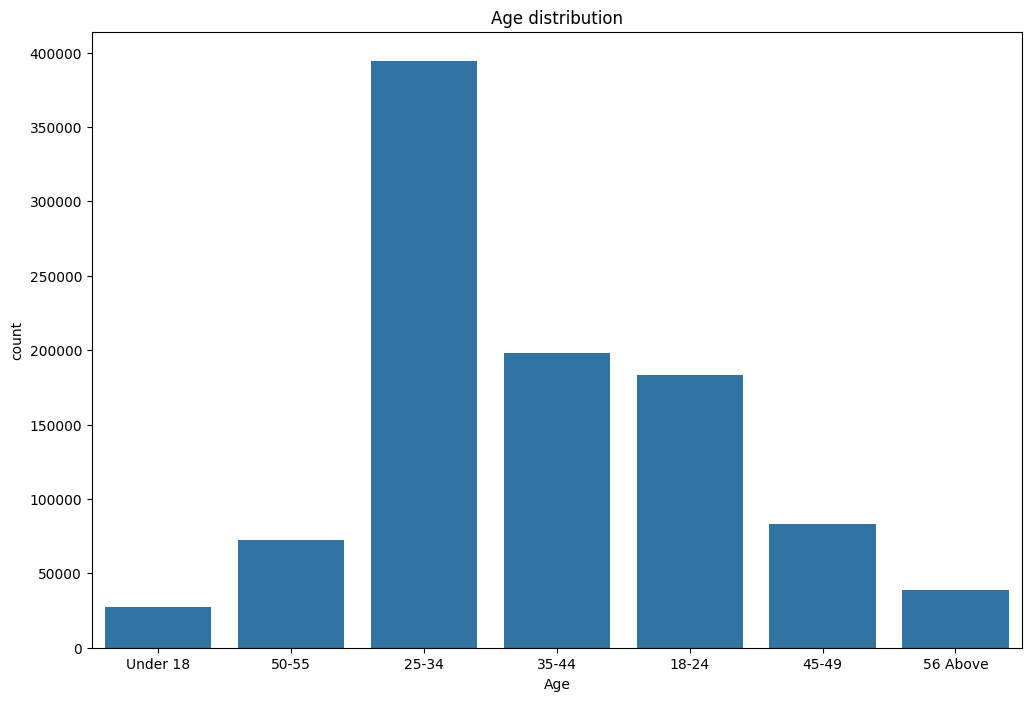

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(x=df_final['Age'])
plt.title('Age distribution')
plt.show()

##### Media consumption is maximum for ages between 25 to 34, hence the business can focus on creating more tailored content for this age range.

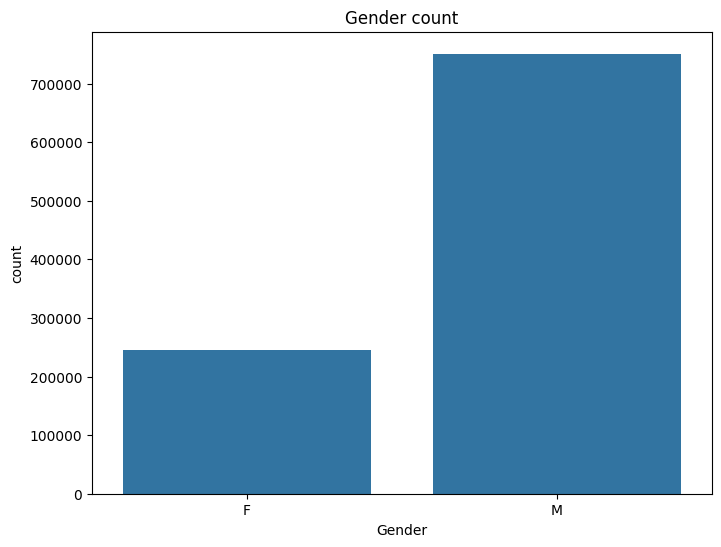

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df_final['Gender'])
plt.title('Gender count')
plt.show()

##### Males consume more content than females

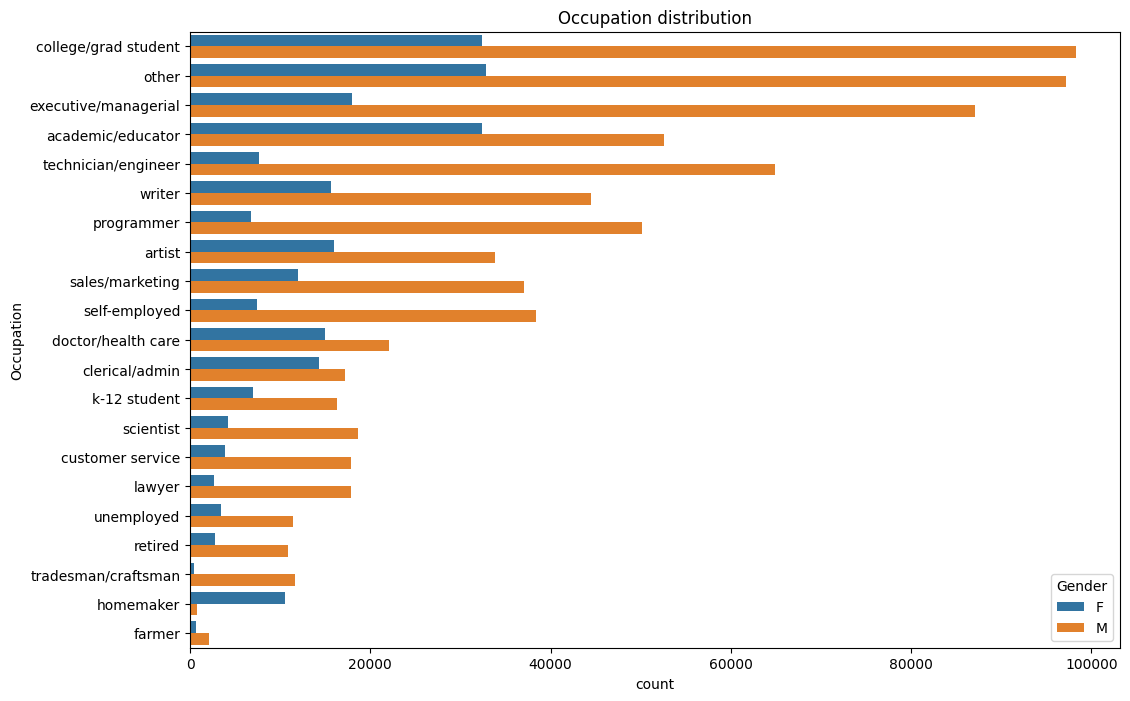

In [ ]:
# Distribution of Occupation.
sorted_counts = df_final['Occupation'].value_counts()
plt.figure(figsize=(12, 8))
sns.countplot(data=df_final, y=df_final['Occupation'], order=sorted_counts.index, hue='Gender')
plt.title('Occupation distribution')
plt.show()

##### College going students are the major consumers of media, which aligns with our age distribution as well.

In [ ]:
df_final

MovieID           Title                       Genres UserID  Rating  \
0             1       Toy Story  Animation|Children's|Comedy      1       5   
1             1       Toy Story  Animation|Children's|Comedy      6       4   
2             1       Toy Story  Animation|Children's|Comedy      8       4   
3             1       Toy Story  Animation|Children's|Comedy      9       5   
4             1       Toy Story  Animation|Children's|Comedy     10       5   
...         ...             ...                          ...    ...     ...   
1000204    3952  Contender, The               Drama|Thriller   5812       4   
1000205    3952  Contender, The               Drama|Thriller   5831       3   
1000206    3952  Contender, The               Drama|Thriller   5837       4   
1000207    3952  Contender, The               Drama|Thriller   5927       1   
1000208    3952  Contender, The               Drama|Thriller   5998       4   

                  Timestamp Gender       Age            Occupation Zip-code  \
0       2001-01-06 23:37:48      F  Under 18          k-12 student    48067   
1       2000-12-31 04:30:08      F     50-55             homemaker    55117   
2       2000-12-31 03:31:36      M     25-34            programmer    11413   
3       2000-12-31 01:25:52      M     25-34   technician/engineer    61614   
4       2000-12-31 01:34:34      F     35-44     academic/educator    95370   
...                     ...    ...       ...                   ...      ...   
1000204 2001-06-09 07:34:59      F     25-34  executive/managerial    92120   
1000205 2001-04-02 14:52:05      M     25-34     academic/educator    92120   
1000206 2002-01-24 20:04:16      M     25-34  executive/managerial    60607   
1000207 2001-01-18 21:15:37      M     35-44       sales/marketing    10003   
1000208 2001-09-29 16:30:44      M     18-24  college/grad student    61820   

         Release Year ReleaseDec  
0                1995        90s  
1                1995        90s  
2                1995        90s  
3                1995        90s  
4                1995        90s  
...               ...        ...  
1000204          2000        90s  
1000205          2000        90s  
1000206          2000        90s  
1000207          2000        90s  
1000208          2000        90s  

[996665 rows x 12 columns]

In [ ]:
# Top 3 Genre by age groups.
df_temp = df_final.groupby(['Age', 'Genres'])['Rating'].mean().reset_index().sort_values(by=['Age', 'Rating'], ascending=[True, False]).groupby('Age').head(3)
df_temp

Age                              Genres    Rating
185      18-24           Animation|Comedy|Thriller  4.562500
4        18-24                          Action|Adv  4.442142
31       18-24             Action|Adventure|Fantas  4.427046
356      25-34                                Acti  5.000000
385      25-34             Action|Adventure|Fantas  4.572695
539      25-34           Animation|Comedy|Thriller  4.506711
841      35-44  Adventure|Children's|Drama|Musical  4.446384
892      35-44           Animation|Comedy|Thriller  4.364238
739      35-44             Action|Adventure|Fantas  4.354633
1337     45-49                            Document  5.000000
1246     45-49           Animation|Comedy|Thriller  4.500000
1228     45-49                           Animation  4.485714
1685     50-55                             Documen  5.000000
1686     50-55                            Document  4.666667
1578     50-55                           Animation  4.611111
1764  56 Above                                      5.000000
2046  56 Above                          Drama|Roma  5.000000
2047  56 Above                         Drama|Roman  4.714286
2362  Under 18                                   D  5.000000
2363  Under 18                                Docu  4.666667
2401  Under 18          Film-Noir|Romance|Thriller  4.666667

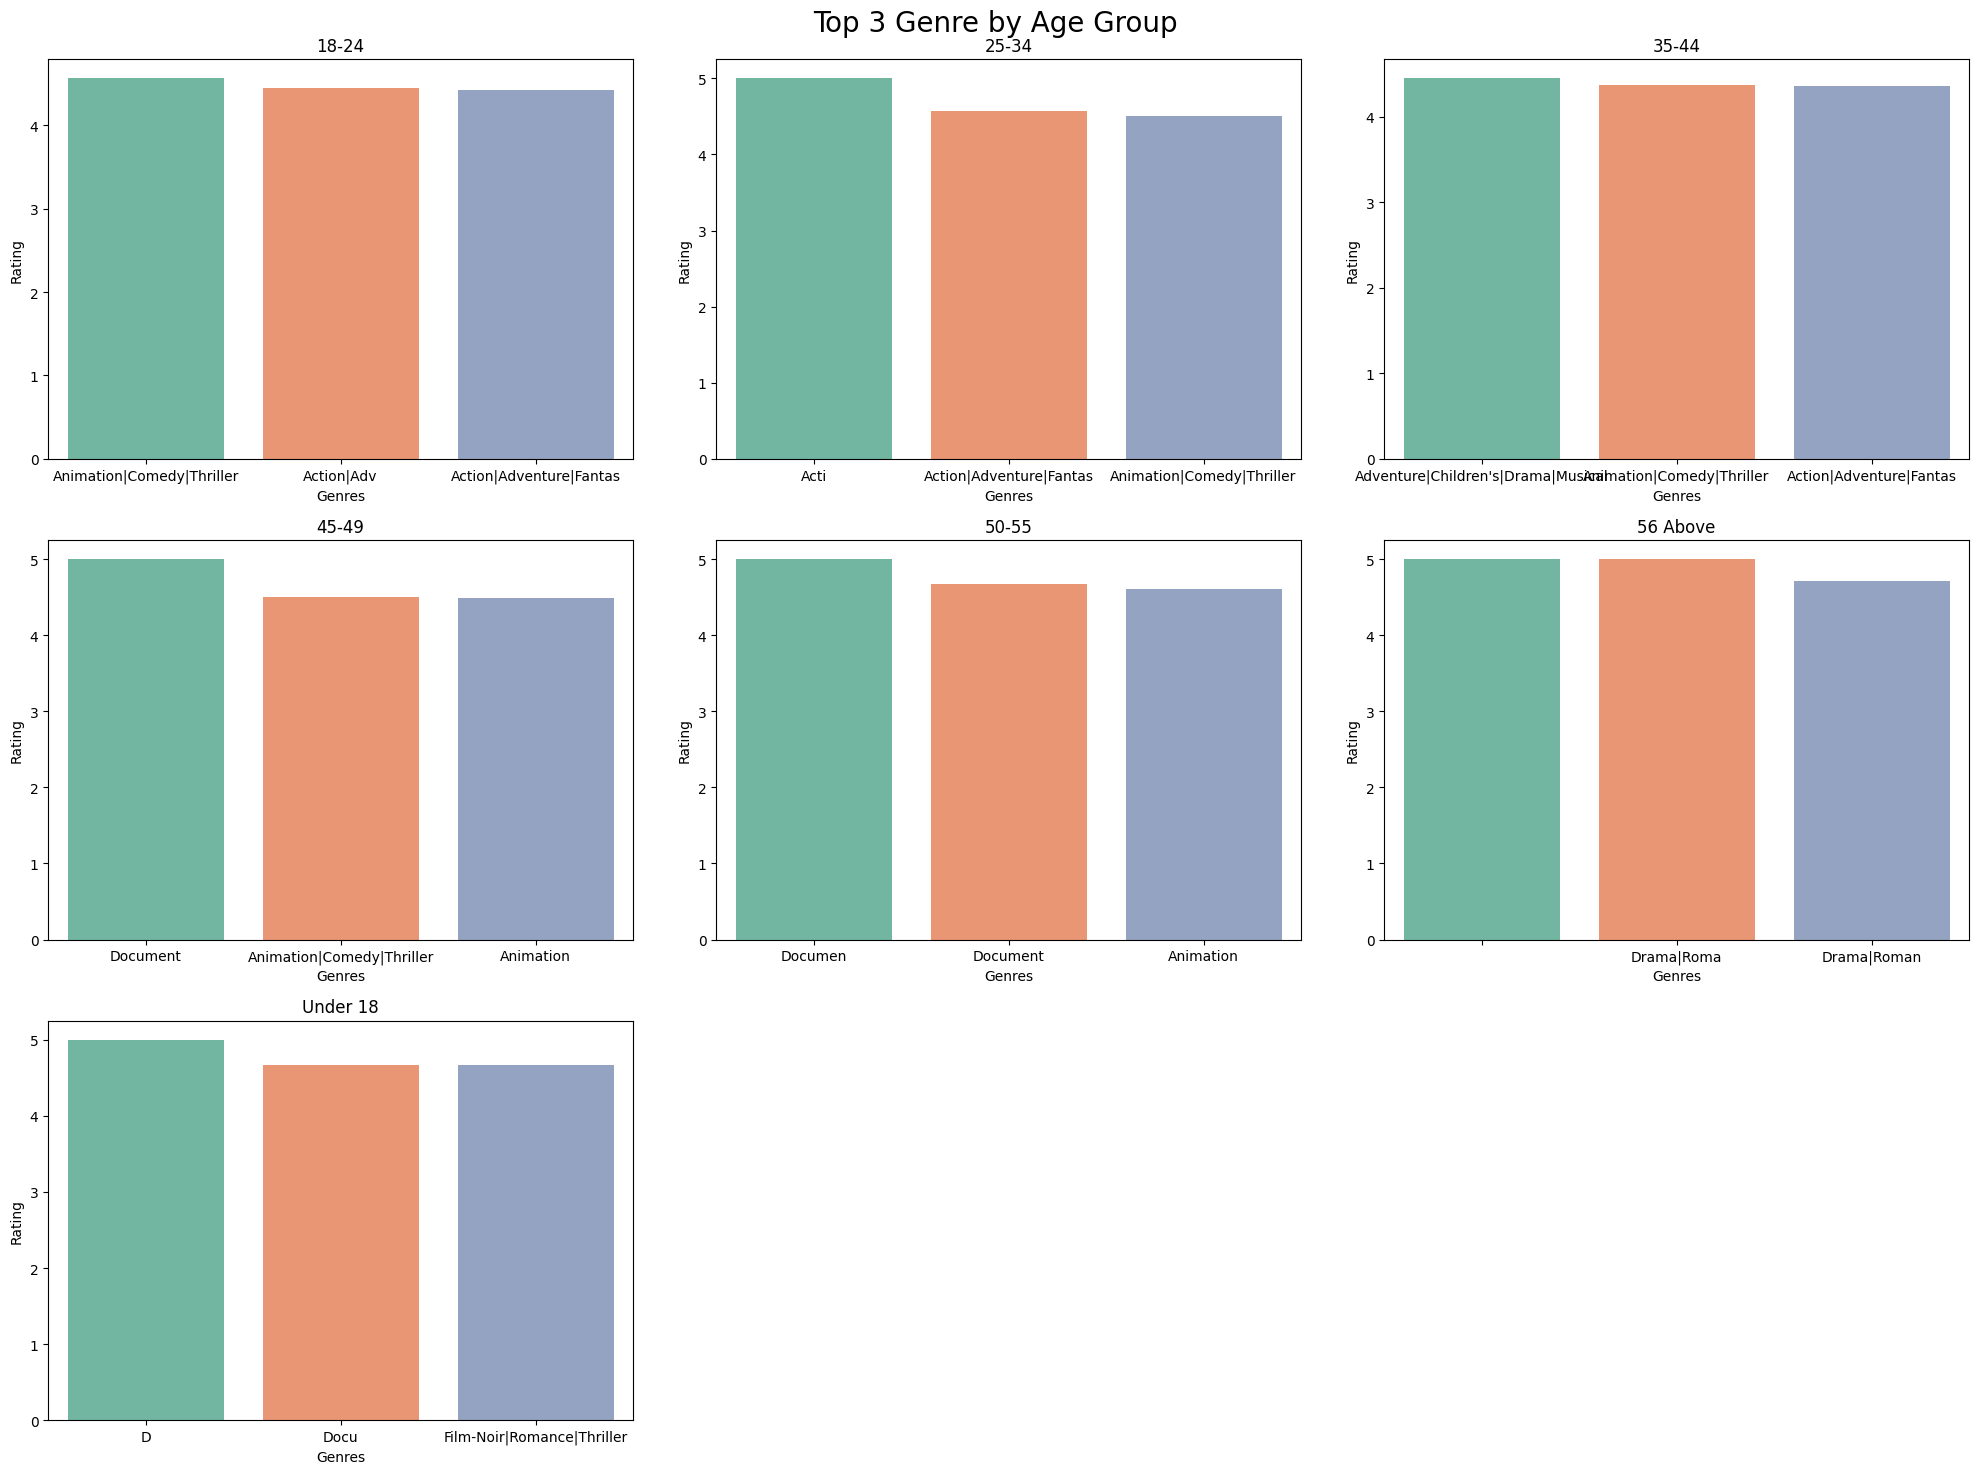

In [ ]:
# Plots for top 3 genre by age groups.
fig, ax = plt.subplots(figsize=(20, 15), nrows=3, ncols=3)
fig.suptitle('Top 3 Genre by Age Group', fontsize=20)

palette = sns.color_palette("Set2")  # Feel free to change to other palettes like "Paired", "tab10", etc.

# Age 18-24
df_age1 = df_temp[df_temp['Age'] == '18-24']
sns.barplot(data=df_age1, x=df_age1['Genres'], y=df_age1['Rating'], ax=ax[0, 0], palette=palette)
ax[0, 0].set_title('18-24')

# Age 25-34
df_age2 = df_temp[df_temp['Age'] == '25-34']
sns.barplot(data=df_age2, x=df_age2['Genres'], y=df_age2['Rating'], ax=ax[0, 1], palette=palette)
ax[0, 1].set_title('25-34')

# Age 35-44
df_age3 = df_temp[df_temp['Age'] == '35-44']
sns.barplot(data=df_age3, x=df_age3['Genres'], y=df_age3['Rating'], ax=ax[0, 2], palette=palette)
ax[0, 2].set_title('35-44')

# Age 45-49
df_age4 = df_temp[df_temp['Age'] == '45-49']
sns.barplot(data=df_age4, x=df_age4['Genres'], y=df_age4['Rating'], ax=ax[1, 0], palette=palette)
ax[1, 0].set_title('45-49')

# Age 50-55
df_age5 = df_temp[df_temp['Age'] == '50-55']
sns.barplot(data=df_age5, x=df_age5['Genres'], y=df_age5['Rating'], ax=ax[1, 1], palette=palette)
ax[1, 1].set_title('50-55')

# Age 56 Above
df_age6 = df_temp[df_temp['Age'] == '56 Above']
sns.barplot(data=df_age6, x=df_age6['Genres'], y=df_age6['Rating'], ax=ax[1, 2], palette=palette)
ax[1, 2].set_title('56 Above')

# Under 18
df_age7 = df_temp[df_temp['Age'] == 'Under 18']
sns.barplot(data=df_age7, x=df_age7['Genres'], y=df_age7['Rating'], ax=ax[2, 0], palette=palette)
ax[2, 0].set_title('Under 18')

fig.tight_layout()
fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

plt.show()

In [ ]:
# Top 10 titles by average rating.
df_final.groupby('Title')['Rating'].mean().reset_index().sort_values(by=['Rating'], ascending=False).head(10)

Title  Rating
1993                               Lured     5.0
2994                       Smashing Time     5.0
1282         Gate of Heavenly Peace, The     5.0
2411                   One Little Indian     5.0
1189                    Follow the Bitch     5.0
404                    Bittersweet Motel     5.0
3421                    Ulysses (Ulisse)     5.0
2855  Schlafes Bruder (Brother of Sleep)     5.0
247                            Baby, The     5.0
3037                     Song of Freedom     5.0

In [ ]:
# Top 10 most rated titles
df_final.groupby('Title')['Rating'].count().reset_index().sort_values(by=['Rating'], ascending=False).head(10)

Title  Rating
125                                  American Beauty    3428
3103              Star Wars: Episode IV - A New Hope    2991
3104  Star Wars: Episode V - The Empire Strikes Back    2990
3105      Star Wars: Episode VI - Return of the Jedi    2883
1764                                   Jurassic Park    2672
2847                             Saving Private Ryan    2653
3242                      Terminator 2: Judgment Day    2649
2078                                     Matrix, The    2590
256                               Back to the Future    2583
2940                       Silence of the Lambs, The    2578

#### Model Building
##### The model will be built using collaborative filtering and we will explore both user-user and item-item based approaches.

In [ ]:
# Taking the mean of rating in case the user gave more than one rating to same title.
df_matrix = df_final.groupby(['UserID', 'Title'])['Rating'].mean().reset_index()

In [ ]:
# Creating interaction table for user, title and rating using pivot table.
interaction_matrix = pd.pivot_table(df_matrix, values='Rating', index='UserID', columns='Title')
interaction_matrix

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   NaN            NaN                 NaN          NaN   
10                  NaN            NaN                 NaN          4.0   
100                 NaN            NaN                 NaN          NaN   
1000                NaN            NaN                 NaN          NaN   
1001                NaN            NaN                 NaN          NaN   
...                 ...            ...                 ...          ...   
995                 NaN            NaN                 NaN          NaN   
996                 NaN            NaN                 NaN          NaN   
997                 NaN            NaN                 NaN          NaN   
998                 NaN            NaN                 NaN          NaN   
999                 NaN            NaN                 NaN          NaN   

Title   ...And Justice for All  1-900  10 Things I Hate About You  \
UserID                                                              
1                          NaN    NaN                         NaN   
10                         NaN    NaN                         NaN   
100                        NaN    NaN                         NaN   
1000                       NaN    NaN                         NaN   
1001                       NaN    NaN                         NaN   
...                        ...    ...                         ...   
995                        NaN    NaN                         NaN   
996                        NaN    NaN                         NaN   
997                        NaN    NaN                         NaN   
998                        NaN    NaN                         NaN   
999                        3.0    NaN                         NaN   

Title   101 Dalmatians  12 Angry Men  13th Warrior, The  ...  \
UserID                                                   ...   
1                  NaN           NaN                NaN  ...   
10                 NaN           3.0                4.0  ...   
100                NaN           NaN                NaN  ...   
1000               4.0           NaN                NaN  ...   
1001               3.0           NaN                NaN  ...   
...                ...           ...                ...  ...   
995                NaN           NaN                NaN  ...   
996                NaN           5.0                NaN  ...   
997                NaN           NaN                NaN  ...   
998                NaN           NaN                NaN  ...   
999                NaN           NaN                NaN  ...   

Title   Young Poisoner's Handbook, The  Young Sherlock Holmes  \
UserID                                                          
1                                  NaN                    NaN   
10                                 NaN                    NaN   
100                                NaN                    NaN   
1000                               NaN                    NaN   
1001                               NaN                    NaN   
...                                ...                    ...   
995                                NaN                    NaN   
996                                NaN                    4.0   
997                                NaN                    NaN   
998                                NaN                    NaN   
999                                NaN                    NaN   

Title   Young and Innocent  Your Friends and Neighbors  Zachariah  \
UserID                                                              
1                      NaN                         NaN        NaN   
10                     NaN                         NaN        NaN   
100                    NaN                         NaN        NaN   
1000                   NaN                         NaN        NaN   
1001                   NaN       

In [ ]:
# Replacing NaN with zeros.
interaction_matrix.fillna(0, inplace=True)

In [ ]:
interaction_matrix

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   0.0            0.0                 0.0          0.0   
10                  0.0            0.0                 0.0          4.0   
100                 0.0            0.0                 0.0          0.0   
1000                0.0            0.0                 0.0          0.0   
1001                0.0            0.0                 0.0          0.0   
...                 ...            ...                 ...          ...   
995                 0.0            0.0                 0.0          0.0   
996                 0.0            0.0                 0.0          0.0   
997                 0.0            0.0                 0.0          0.0   
998                 0.0            0.0                 0.0          0.0   
999                 0.0            0.0                 0.0          0.0   

Title   ...And Justice for All  1-900  10 Things I Hate About You  \
UserID                                                              
1                          0.0    0.0                         0.0   
10                         0.0    0.0                         0.0   
100                        0.0    0.0                         0.0   
1000                       0.0    0.0                         0.0   
1001                       0.0    0.0                         0.0   
...                        ...    ...                         ...   
995                        0.0    0.0                         0.0   
996                        0.0    0.0                         0.0   
997                        0.0    0.0                         0.0   
998                        0.0    0.0                         0.0   
999                        3.0    0.0                         0.0   

Title   101 Dalmatians  12 Angry Men  13th Warrior, The  ...  \
UserID                                                   ...   
1                  0.0           0.0                0.0  ...   
10                 0.0           3.0                4.0  ...   
100                0.0           0.0                0.0  ...   
1000               4.0           0.0                0.0  ...   
1001               3.0           0.0                0.0  ...   
...                ...           ...                ...  ...   
995                0.0           0.0                0.0  ...   
996                0.0           5.0                0.0  ...   
997                0.0           0.0                0.0  ...   
998                0.0           0.0                0.0  ...   
999                0.0           0.0                0.0  ...   

Title   Young Poisoner's Handbook, The  Young Sherlock Holmes  \
UserID                                                          
1                                  0.0                    0.0   
10                                 0.0                    0.0   
100                                0.0                    0.0   
1000                               0.0                    0.0   
1001                               0.0                    0.0   
...                                ...                    ...   
995                                0.0                    0.0   
996                                0.0                    4.0   
997                                0.0                    0.0   
998                                0.0                    0.0   
999                                0.0                    0.0   

Title   Young and Innocent  Your Friends and Neighbors  Zachariah  \
UserID                                                              
1                      0.0                         0.0        0.0   
10                     0.0                         0.0        0.0   
100                    0.0                         0.0        0.0   
1000                   0.0                         0.0        0.0   
1001                   0.0       

##### Recommendation with Pearson correlation

###### Item based approach

In [ ]:
# Input a movie title.
movie = input('Enter movie title: ')
print(f"Movie title: {movie}")

Enter movie title: Terminator, The
Movie title: Terminator, The


In [ ]:
# Getting the top 5 movies with the highest correlation.
movie_rating_vector = interaction_matrix[movie]
similar_movies = interaction_matrix.corrwith(movie_rating_vector)
similar_movies_df = pd.DataFrame(similar_movies, columns=['Correlation'])
similar_movies_df.sort_values(by=['Correlation'], ascending=False, inplace=True)
similar_movies_df.iloc[1:6]

Correlation
Title                                  
Aliens                         0.625018
Predator                       0.577138
Die Hard                       0.575858
Alien                          0.563853
Terminator 2: Judgment Day     0.562806

##### We can see above that for a given movie title 'Terminator', which is an Action/Sci-Fi genre, we get movies within similar genre. You can try for other titles!

##### Recommendation with Cosine Similarity
###### Cosine similarity gives an estimate if two vectors are point roughly in the same direction. The values varies between -1 and 1.
###### In our case, we will measure the similarity between the movie input by the user with all the movies in the data.

In [ ]:
# Item-Item based similarity
item_sim = cosine_similarity(interaction_matrix.transpose())
item_sim

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [ ]:
item_sim_matrix = pd.DataFrame(item_sim, columns=interaction_matrix.columns, index=interaction_matrix.columns)
item_sim_matrix

Title                                $1,000,000 Duck  'Night Mother  \
Title                                                                 
$1,000,000 Duck                             1.000000       0.072357   
'Night Mother                               0.072357       1.000000   
'Til There Was You                          0.037011       0.115290   
'burbs, The                                 0.079291       0.115545   
...And Justice for All                      0.060838       0.159526   
...                                              ...            ...   
Zed & Two Noughts, A                        0.045280       0.091150   
Zero Effect                                 0.039395       0.074787   
Zero Kelvin (Kjærlighetens kjøtere)         0.000000       0.000000   
Zeus and Roxanne                            0.120242       0.000000   
eXistenZ                                    0.027003       0.077807   

Title                                'Til There Was You  'burbs, The  \
Title                                                                  
$1,000,000 Duck                                0.037011     0.079291   
'Night Mother                                  0.115290     0.115545   
'Til There Was You                             1.000000     0.098756   
'burbs, The                                    0.098756     1.000000   
...And Justice for All                         0.066301     0.143620   
...                                                 ...          ...   
Zed & Two Noughts, A                           0.022594     0.055704   
Zero Effect                                    0.079261     0.161174   
Zero Kelvin (Kjærlighetens kjøtere)            0.000000     0.000000   
Zeus and Roxanne                               0.047526     0.033567   
eXistenZ                                       0.063284     0.110525   

Title                                ...And Justice for All     1-900  \
Title                                                                   
$1,000,000 Duck                                    0.060838  0.000000   
'Night Mother                                      0.159526  0.000000   
'Til There Was You                                 0.066301  0.080250   
'burbs, The                                        0.143620  0.000000   
...And Justice for All                             1.000000  0.000000   
...                                                     ...       ...   
Zed & Two Noughts, A                               0.086080  0.000000   
Zero Effect                                        0.110867  0.000000   
Zero Kelvin (Kjærlighetens kjøtere)                0.074317  0.000000   
Zeus and Roxanne                                   0.000000  0.000000   
eXistenZ                                           0.111040  0.039561   

Title                                10 Things I Hate About You  \
Title                                                             
$1,000,000 Duck                                        0.058619   
'Night Mother                                          0.076798   
'Til There Was You                                     0.127895   
'burbs, The                                            0.192191   
...And Justice for All                                 0.075093   
...                                                         ...   
Zed & Two Noughts, A                                   0.012702   
Zero Effect                                            0.175771   
Zero Kelvin (Kjærlighetens kjøtere)                    0.000000   
Zeus and Roxanne                                       0.058708   
eXistenZ                                               0.162060   

Title                                101 Dalmatians  12 Angry Men  \
Title                                                               
$1,000,000 Duck                            0.189843      0.094785   
'Night Mother                              0.137135      0.111413   
'Til There Was You                       

In [ ]:
# Testing item-item recommendations
movie = input('Enter movie title: ')
print(f"Movie title: {movie}")

Enter movie title: Liar Liar
Movie title: Liar Liar


In [ ]:
#We can see similar quality of recommendations for cosine similarity.
item_sim_matrix[movie].sort_values(ascending=False).iloc[1:6]

Title
Mrs. Doubtfire                0.557067
Ace Ventura: Pet Detective    0.516861
Dumb & Dumber                 0.512585
Home Alone                    0.511204
Wayne's World                 0.499368
Name: Liar Liar, dtype: float64

In [ ]:
df_final['UserID'] = df_final['UserID'].astype(int)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996665 entries, 0 to 1000208
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   MovieID       996665 non-null  object        
 1   Title         996665 non-null  object        
 2   Genres        996144 non-null  object        
 3   UserID        996665 non-null  int64         
 4   Rating        996665 non-null  int64         
 5   Timestamp     996665 non-null  datetime64[ns]
 6   Gender        996665 non-null  object        
 7   Age           996665 non-null  object        
 8   Occupation    996665 non-null  object        
 9   Zip-code      996665 non-null  object        
 10  Release Year  996665 non-null  int64         
 11  ReleaseDec    996620 non-null  category      
dtypes: category(1), datetime64[ns](1), int64(3), object(7)
memory usage: 92.2+ MB


##### User-user based approach

In [ ]:
# User-user based recommendation.

user_sim = cosine_similarity(interaction_matrix)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [ ]:
user_sim_matrix = pd.DataFrame(user_sim, columns=interaction_matrix.index, index=interaction_matrix.index)
user_sim_matrix

UserID         1        10       100      1000      1001      1002      1003  \
UserID                                                                         
1       1.000000  0.255319  0.123967  0.207800  0.139317  0.110320  0.121384   
10      0.255319  1.000000  0.259645  0.280479  0.158703  0.112917  0.141985   
100     0.123967  0.259645  1.000000  0.306067  0.075736  0.110450  0.358686   
1000    0.207800  0.280479  0.306067  1.000000  0.099117  0.047677  0.201722   
1001    0.139317  0.158703  0.075736  0.099117  1.000000  0.164854  0.053887   
...          ...       ...       ...       ...       ...       ...       ...   
995     0.035731  0.146552  0.033754  0.044404  0.109700  0.072578  0.031406   
996     0.170184  0.304806  0.344290  0.330748  0.222119  0.224779  0.185226   
997     0.159267  0.165700  0.204302  0.172803  0.103255  0.068980  0.170771   
998     0.119356  0.133327  0.113522  0.098456  0.269952  0.218905  0.141829   
999     0.122391  0.248450  0.306937  0.250564  0.178399  0.178474  0.198656   

UserID      1004      1005      1006  ...       990       991       992  \
UserID                                ...                                 
1       0.180226  0.103896  0.052816  ...  0.079367  0.038048  0.032136   
10      0.432536  0.194915  0.102487  ...  0.154412  0.186234  0.083739   
100     0.237492  0.172872  0.099147  ...  0.098235  0.097953  0.065152   
1000    0.355920  0.325966  0.130702  ...  0.170100  0.076779  0.000000   
1001    0.150196  0.138602  0.134710  ...  0.146270  0.026891  0.097011   
...          ...       ...       ...  ...       ...       ...       ...   
995     0.088838  0.061450  0.032265  ...  0.080559  0.252222  0.074207   
996     0.352014  0.287965  0.164045  ...  0.205186  0.086546  0.062523   
997     0.175488  0.106303  0.049536  ...  0.192642  0.030588  0.081380   
998     0.075538  0.112029  0.052900  ...  0.061241  0.074269  0.086398   
999     0.334470  0.164777  0.143866  ...  0.214809  0.085280  0.040307   

UserID       993       994       995       996       997       998       999  
UserID                                                                        
1       0.067631  0.070052  0.035731  0.170184  0.159267  0.119356  0.122391  
10      0.125894  0.118558  0.146552  0.304806  0.165700  0.133327  0.248450  
100     0.178664  0.271311  0.033754  0.344290  0.204302  0.113522  0.306937  
1000    0.200343  0.380741  0.044404  0.330748  0.172803  0.098456  0.250564  
1001    0.119609  0.092234  0.109700  0.222119  0.103255  0.269952  0.178399  
...          ...       ...       ...       ...       ...       ...       ...  
995     0.098705  0.048650  1.000000  0.063925  0.019459  0.075830  0.052571  
996     0.186441  0.217672  0.063925  1.000000  0.179404  0.178834  0.418466  
997     0.162615  0.110656  0.019459  0.179404  1.000000  0.186575  0.185639  
998     0.166462  0.018659  0.075830  0.178834  0.186575  1.000000  0.108271  
999     0.168252  0.161995  0.052571  0.418466  0.185639  0.108271  1.000000  

[6040 rows x 6040 columns]

In [ ]:
# Top 5 users similar to UserID 1
user_sim_matrix['1'].sort_values(ascending=False).iloc[1:6].reset_index()

UserID         1
0   5343  0.412117
1   5190  0.411899
2   1481  0.392110
3   1283  0.386597
4   5705  0.360898

In [ ]:
# Recommending UserID 1 with the top-rated movies of UserID 5343.
df_final[df_final['UserID'] == 5343].sort_values(by='Rating', ascending=False).head(5)['Title']

1822                       Toy Story
275585    E.T. the Extra-Terrestrial
894496               Erin Brockovich
876313                   Boiler Room
838098                   Toy Story 2
Name: Title, dtype: object

#### Recommendation using Nearest Neighbours

In [ ]:
# Initializing and fitting the model.
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(interaction_matrix.transpose())

NearestNeighbors(metric='cosine', n_jobs=-1)

In [ ]:
movie_name = input('Enter movie title: ')
print(f"Movie title: {movie_name}")

Enter movie title: E.T. the Extra-Terrestrial
Movie title: E.T. the Extra-Terrestrial


In [ ]:
movie_rating_vector = interaction_matrix[movie_name].values.reshape(1,-1)
distances, indices = knn.kneighbors(movie_rating_vector, n_neighbors=10)

In [ ]:
indices

array([[ 997, 3104,  256, 3103,  707, 3105, 3243, 2666,  373,  100]])

In [ ]:
distances

array([[6.66133815e-16, 3.41503600e-01, 3.55167911e-01, 3.55846274e-01,
        3.93512648e-01, 3.96135929e-01, 4.02684191e-01, 4.11986081e-01,
        4.14823636e-01, 4.30333688e-01]])

In [ ]:
interaction_matrix

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   0.0            0.0                 0.0          0.0   
10                  0.0            0.0                 0.0          4.0   
100                 0.0            0.0                 0.0          0.0   
1000                0.0            0.0                 0.0          0.0   
1001                0.0            0.0                 0.0          0.0   
...                 ...            ...                 ...          ...   
995                 0.0            0.0                 0.0          0.0   
996                 0.0            0.0                 0.0          0.0   
997                 0.0            0.0                 0.0          0.0   
998                 0.0            0.0                 0.0          0.0   
999                 0.0            0.0                 0.0          0.0   

Title   ...And Justice for All  1-900  10 Things I Hate About You  \
UserID                                                              
1                          0.0    0.0                         0.0   
10                         0.0    0.0                         0.0   
100                        0.0    0.0                         0.0   
1000                       0.0    0.0                         0.0   
1001                       0.0    0.0                         0.0   
...                        ...    ...                         ...   
995                        0.0    0.0                         0.0   
996                        0.0    0.0                         0.0   
997                        0.0    0.0                         0.0   
998                        0.0    0.0                         0.0   
999                        3.0    0.0                         0.0   

Title   101 Dalmatians  12 Angry Men  13th Warrior, The  ...  \
UserID                                                   ...   
1                  0.0           0.0                0.0  ...   
10                 0.0           3.0                4.0  ...   
100                0.0           0.0                0.0  ...   
1000               4.0           0.0                0.0  ...   
1001               3.0           0.0                0.0  ...   
...                ...           ...                ...  ...   
995                0.0           0.0                0.0  ...   
996                0.0           5.0                0.0  ...   
997                0.0           0.0                0.0  ...   
998                0.0           0.0                0.0  ...   
999                0.0           0.0                0.0  ...   

Title   Young Poisoner's Handbook, The  Young Sherlock Holmes  \
UserID                                                          
1                                  0.0                    0.0   
10                                 0.0                    0.0   
100                                0.0                    0.0   
1000                               0.0                    0.0   
1001                               0.0                    0.0   
...                                ...                    ...   
995                                0.0                    0.0   
996                                0.0                    4.0   
997                                0.0                    0.0   
998                                0.0                    0.0   
999                                0.0                    0.0   

Title   Young and Innocent  Your Friends and Neighbors  Zachariah  \
UserID                                                              
1                      0.0                         0.0        0.0   
10                     0.0                         0.0        0.0   
100                    0.0                         0.0        0.0   
1000                   0.0                         0.0        0.0   
1001                   0.0       

In [ ]:
# Getting the top 10 recommendations for the given movie title.
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(f"Movie title: {interaction_matrix.columns[indices.flatten()[i]]}, Distance: {round(distances.flatten()[i], 3)}")

Movie title: Star Wars: Episode V - The Empire Strikes Back, Distance: 0.342
Movie title: Back to the Future, Distance: 0.355
Movie title: Star Wars: Episode IV - A New Hope, Distance: 0.356
Movie title: Close Encounters of the Third Kind, Distance: 0.394
Movie title: Star Wars: Episode VI - Return of the Jedi, Distance: 0.396
Movie title: Terminator, The, Distance: 0.403
Movie title: Raiders of the Lost Ark, Distance: 0.412
Movie title: Big, Distance: 0.415
Movie title: Aliens, Distance: 0.43


##### We can compare our recommendations with Google recommendations.
##### For 'E.T. the Extra-Terrestrial' we can observe 5 matching recommendations.

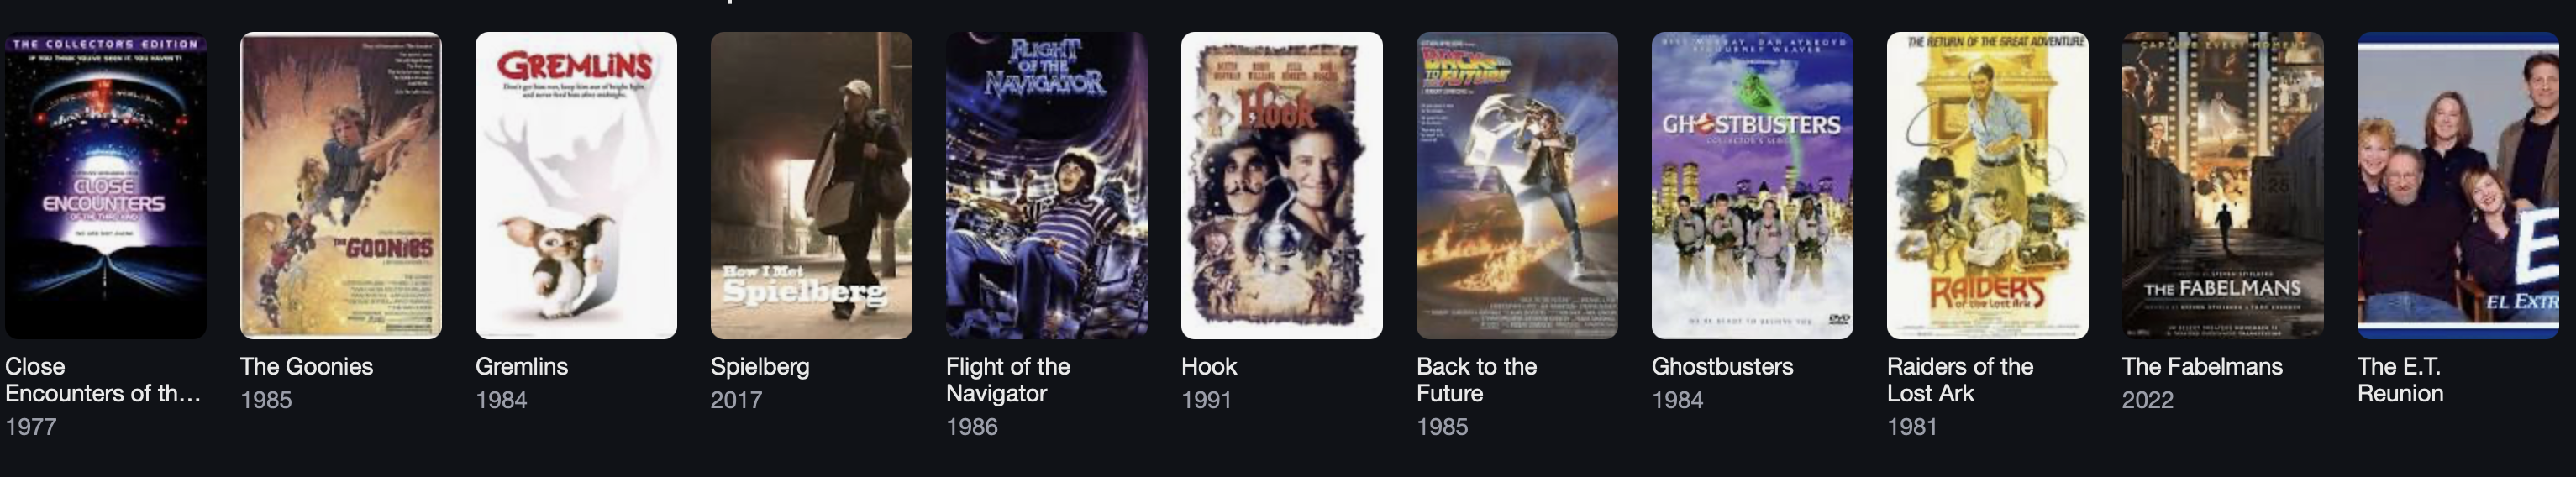

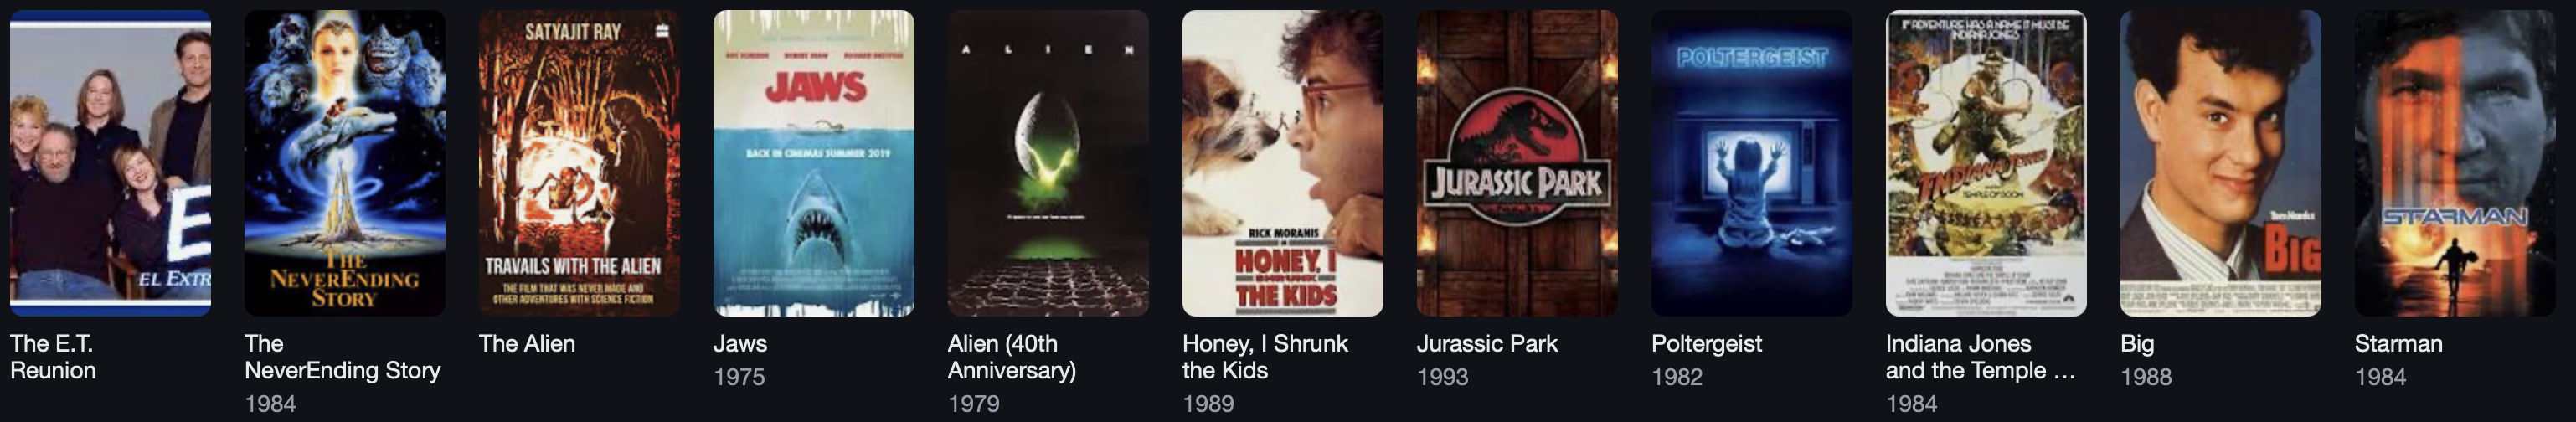

#### Matrix Factorization

In [ ]:
# Converting our matrix into a format that is accepted in the 'Collective Matrix Factorization(CMF)' Model.
df_final1 = df_final.groupby(['UserID', 'MovieID'])['Rating'].mean().reset_index()
df_final1

UserID MovieID  Rating
0            1       1     5.0
1            1    1022     5.0
2            1    1028     5.0
3            1    1029     5.0
4            1    1035     5.0
...        ...     ...     ...
996660    6040     924     5.0
996661    6040     930     4.0
996662    6040     953     5.0
996663    6040     978     4.0
996664    6040     994     3.0

[996665 rows x 3 columns]

In [ ]:
# The column names need to be specified in the following format.
df_final1.columns = ['UserId', 'ItemId', 'Rating']
df_final1

UserId ItemId  Rating
0            1      1     5.0
1            1   1022     5.0
2            1   1028     5.0
3            1   1029     5.0
4            1   1035     5.0
...        ...    ...     ...
996660    6040    924     5.0
996661    6040    930     4.0
996662    6040    953     5.0
996663    6040    978     4.0
996664    6040    994     3.0

[996665 rows x 3 columns]

In [ ]:
# Initializing and fitting the CMF model.
# We observed best recommending performance at latent factor(k) = 50
model = CMF(k = 50, lambda_ = 0.1, method = 'als', verbose = False, user_bias= True, item_bias=True)
model.fit(df_final1)

Collective matrix factorization model
(explicit-feedback variant)


##### Checking the decomposed matrices

In [ ]:
model.A_.shape

(6040, 50)

In [ ]:
model.B_.shape

(3688, 50)

In [ ]:
model.A_

array([[-0.16706257, -0.35628554, -0.14455456, ...,  0.39382768,
         0.04093885, -0.32932538],
       [ 0.10144717,  0.30729926, -0.5309012 , ...,  0.21462575,
        -0.06860225, -0.28082377],
       [-0.39914042, -0.04626046, -0.02366884, ..., -0.20249115,
        -0.37193012, -0.38056582],
       ...,
       [ 0.21973656,  0.01960473, -0.20451277, ...,  0.02273694,
        -0.12490839,  0.00506723],
       [-0.1071611 , -0.07584582, -0.22551583, ..., -0.28220692,
         0.0041018 , -0.24443078],
       [-0.10558881, -0.10045871,  0.26245502, ...,  0.04204621,
         0.01344272,  0.35875246]], dtype=float32)

In [ ]:
model.B_

array([[-0.7873716 ,  0.19960643,  0.01308054, ...,  0.02991598,
         0.59776944, -0.23912615],
       [-0.36509898,  0.56811374, -0.5646395 , ...,  0.21436879,
         0.6762797 , -1.3015836 ],
       [-0.246014  , -0.5008277 , -1.8349698 , ...,  0.36713484,
         0.38827312, -0.65988714],
       ...,
       [-0.22341384,  0.10702207,  0.13441163, ..., -0.11515591,
        -0.01904523, -0.01908816],
       [-0.00340707, -0.05343762,  0.02886893, ...,  0.02659353,
         0.01845852,  0.00206733],
       [ 0.00820245, -0.02194587, -0.02037143, ...,  0.01758214,
         0.01198719, -0.00586766]], dtype=float32)

In [ ]:
model.glob_mean_

3.5799641609191895

In [ ]:
# Testing recommendations for users (here, user id = 5343)
top_items = model.topN(user = 5343, n = 10)
top_items

array(['3194', '2041', '2384', '957', '3742', '1395', '34', '3554',
       '3598', '3457'], dtype=object)

In [ ]:
# Checking the recommended movies.
movies.loc[movies.MovieID.isin(top_items)]

MovieID                                              Title  \
33        34                                        Babe (1995)   
945      957                         Scarlet Letter, The (1926)   
1374    1395                                     Tin Men (1987)   
1972    2041                                   Condorman (1981)   
2315    2384                       Babe: Pig in the City (1998)   
3125    3194                            Way We Were, The (1973)   
3388    3457                             Waking the Dead (1999)   
3485    3554                         Love and Basketball (2000)   
3529    3598                                      Hamlet (2000)   
3673    3742  Battleship Potemkin, The (Bronenosets Potyomki...   

                                  Genres  
33               Children's|Comedy|Drama  
945                                Drama  
1374                        Comedy|Drama  
1972  Action|Adventure|Children's|Comedy  
2315                   Children's|Comedy  
3125                               Drama  
3388                               Drama  
3485                       Drama|Romance  
3529                               Drama  
3673                            Drama|Wa

In [ ]:
# For comparison with our recommended movies, we get the list of top 10 highly rated movies by this user(5343).
df_final[df_final['UserID'] == 5343].sort_values(by='Rating', ascending=False)[['Title','Genres']].head(10)

Title                                  Genres
1822                     Toy Story             Animation|Children's|Comedy
275585  E.T. the Extra-Terrestrial          Children's|Drama|Fantasy|Sci-F
894496             Erin Brockovich                                   Drama
876313                 Boiler Room                                   Drama
838098                 Toy Story 2             Animation|Children's|Comedy
769658             American Beauty                            Comedy|Drama
747671            Sixth Sense, The                                Thriller
569766         Little Mermaid, The   Animation|Children's|Comedy|Musical|R
568765          Lady and the Tramp  Animation|Children's|Comedy|Musical|Ro
567896            Jungle Book, The     Animation|Children's|Comedy|Musical

##### We can observe that the recommended genres of the movies is very close to what this user likes.

*-----------------------------------------------------------------------------------------------------------------------------------------------------------------*